# =============================================================

#  Predicting Customer Churn with Spark Machine Learning & Magellan

# =============================================================

What is Magellan ?
- Magellan is a flexible, AI-powered Analytics platform that combines open source ML with advanced analytics, enterprise-grade BI, and capabilities to acquire, merge, manage and analyze Big Data and Big Content stored in your Enterprise Information Management (EIM) systems. Magellan enables machine-assisted decision making, automation, and business optimization.


What is Spark Machine Learning ?

- Apache Spark’s machine learning library makes practical machine learning scalable and easy. The library consists of common machine learning algorithms and utilities, including classification, regression, clustering, collaborative filtering, dimensionality reduction, lower-level optimization primitives, and higher-level pipeline APIs.

What is this Notebook about?
- In this magellan notebook, you will use Apache Spark and the Spark machine learning library to build a Customer Churn Prediction model.

- Customer Churn refers to when a customer ceases to complete target actions (e.g. add to cart, leave a comment, etc.) within a given period of time OR when a customer ceases his or her relationship with a company. 
- Thus, predicting “likely-to-churn” from engaged customers will allow us to:

    1. Analyze the reasons for such behavior 
    2. Refocus and personalize offerings for different groups of churning customers
    3. Proactivley target likely to churn customers with customized offerings
   
What are the Notebook Requirements?

- This notebook uses Pyspark2 kernel (pre configured to integrate with other parts of magellan, includes multiple open source libraries and ready to leverage big data tools like apache spark)
- Customer Data stored in magellan data lake / hadoop
- Sample data for making predictions in BDA - "churndata_test"
- Magellan 20.2 version

# =============================================================

# In this notebook, you will learn how to:

1. Load data stored in Magellan Data Lake / Hadoop Distributed File System (HDFS)
2. Conduct data exploration
3. Clean and prepare data for model building
4. Create a machine learning pipeline using Apache Spark
5. Train, test and evaluate a model
6. Store a machine learning pipeline in the Magellan Data Lake Hadoop Repository
7. Explore and visualize the prediction results
8. Publish & deploy a machine learning pipeline - so that operational users can access the model and make predictions

# =============================================================

# 1. Load data from the magellan data lake


In [1]:
#load the customer data with relevant columns only
customers_data = spark.sql("select age, age_numeric, churn, days_since_last_login, income,\
 gender_decode, occupation_decode, orders, product_count from customer_churn.historical_churn_data")


# 2. Conduct data exploration


- Check the type of variables
- Count number of records
- Check distribution of target label
- Check Missing Values % 

In [2]:
customers_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- age_numeric: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- days_since_last_login: double (nullable = true)
 |-- income: double (nullable = true)
 |-- gender_decode: string (nullable = true)
 |-- occupation_decode: string (nullable = true)
 |-- orders: integer (nullable = true)
 |-- product_count: integer (nullable = true)



In [3]:
print('There are {0} customer records'.format(customers_data.count(),',d'))

There are 259874 customer records


In [4]:
# import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

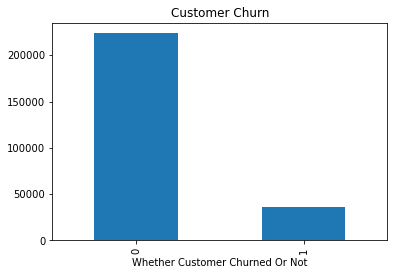

In [5]:
data = customers_data.toPandas()
data['churn'].value_counts().plot(kind = 'bar')
plt.xlabel('Whether Customer Churned Or Not')
plt.title('Customer Churn')
plt.show()

- % of missing values in each column


In [6]:
((data.isnull().sum()/data.shape[0])*100).round(decimals=2)

age                       0.00
age_numeric               0.00
churn                     0.00
days_since_last_login     0.00
income                   13.45
gender_decode             6.04
occupation_decode         0.01
orders                    0.00
product_count             0.00
dtype: float64

# 3. Clean and Impute Missing Data for model building


- Replace numerical columns with median value
- Replace categorical / text columns with "NA"

In [7]:
# Only select numerical columns 
num_cols = [col_type[0] for col_type in filter(lambda dtype: dtype[1] in {"bigint", "double", "int"}, customers_data.dtypes)]

# Compute a dictionary with <col_name, median_value>
median_dict = dict()

# for each column compute median value for it 
for c in num_cols:
       median_dict[c] = customers_data.stat.approxQuantile(c, [0.5], 0.001)[0]
        
# fill in missing values for each column with median value
customers_data = customers_data.na.fill(median_dict)

In [8]:
# fill in values for categorical column with NA
customers_data = customers_data.fillna('NA', 'gender_decode')
customers_data = customers_data.fillna('NA', 'occupation_decode')


# Summary Statistics

In [9]:
summary = customers_data.toPandas().describe().transpose()
summary

,count,mean,std,min,25%,50%,75%,max
age,259874.0,46.843082,9.919787,21.00,40.00,47.00,53.000,94.00
churn,259874.0,0.139267,0.346226,0.00,0.00,0.00,0.000,1.00
days_since_last_login,259874.0,12.520929,13.614087,0.25,2.50,7.50,17.000,120.96
income,259874.0,24982.319681,16043.830771,479.79,14932.15,19609.66,32884.425,113334.75
orders,259874.0,3.576295,4.126803,1.00,1.00,2.00,3.000,20.00
product_count,259874.0,6.856023,6.761355,1.00,3.00,5.00,8.000,40.00


# Insights from above summary table
- Average age is about 46 years
- About 14% of the customers churned
- On average. days since last login for the overall population is 12 days
- Average income of customers is approx $25,000
- On average, customers have made 3 orders
- On average, customers have purchased 6+ products

# Advanced Visuals & More Insights
- Insights: Income distribution increases with age

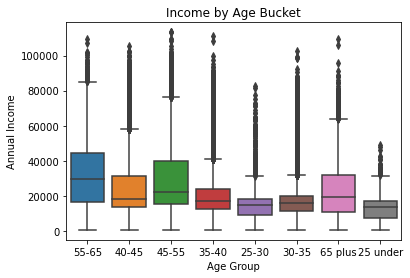

In [10]:
sns.boxplot(x="age_numeric", y="income", data=data).set_title('Income by Age Bucket')
plt.xlabel("Age Group")
plt.ylabel("Annual Income")
plt.show()

# 4. Create a machine learning pipeline using Apache Spark


A pipeline is a method of organizing machine learning algorithms into a workflow for reuse.
This method builds a sequence of activity stages for analysis, such as defining feature parameters, estimating data, and transforming data. You can test and write a pipeline in the
Magellan Notebook and then publish it to Magellan Data Discovery to enable users to apply the pipeline to their own data sets.

As an example, here we are building a pipleine that predicts whether or not a customer will churn based on various demographic and product usage characteristics about the customer. 

Stages in Customer Churn Model Pipeline:
1. We will organize data into required format so that a machine learning algorithm can learn a pattern relating to churn. 
2. We will specify the inputs for the Machine learning algorithm to train a model on
3. We will use decision tree algorithm to predict whether customer will churn or not
4. We will initialize the pipeline with a training data set. The initialized pipeline is then saved as a model in the Magellan data lake and then published to Data Discovery

In [11]:
# Upload spark utility packages
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer,VectorAssembler, OneHotEncoder
from pyspark.mllib.evaluation import BinaryClassificationMetrics

- Stage 1 - setup the right variable format


In [12]:
stages = [] # stages in our Pipeline

cat_input_all = ['occupation_decode', 'gender_decode', 'age_numeric']
cat_input = ['occupation_decode', 'gender_decode'] # age is not being used

# Category Indexing with StringIndexer
indexers = [StringIndexer(inputCol = column, outputCol = column+"_index") for column in cat_input]

# Use OneHotEncoder to convert categorical variables into binary SparseVectors
encoders = [OneHotEncoder(inputCol = column+"_index", outputCol = column+"_dummy") for column in cat_input]

# numerical columns
num_input = list(set(customers_data.columns) - set(['churn']) - set(cat_input_all))

# convert churn to label
labelIndexer = StringIndexer(inputCol="churn", outputCol="label").fit(customers_data.select("churn"))

- Stage 2 - assemble and join columns required for building a model


In [13]:
input_cols = []
for i in cat_input:
      input_cols.append(i+"_dummy")
for i in num_input:
      input_cols.append(i)
        
# assemble all inputs
assembler = VectorAssembler(inputCols= input_cols, outputCol="features")

# 5. Train, test and evaluate a decision tree model

Decision trees generate white-box classification and regression models which can be used for feature selection and sample prediction. The transparency of these models is a big advantage over black-box learners, because the models are easy to understand and interpret, and they can be readily extracted and implemented in any programming language (with nested if-else statements) for use in production environments. Furthermore, decision trees require almost no data preparation (ie normalization) and can handle both categorical and continuous data. To remedy over-fitting and improve prediction accuracy, decision trees can also be limited to a certain depth or complexity, or bundled into ensembles of trees (ie random forests).

A decision tree is a predictive model which maps observations (features) about an item to conclusions about the item's label or class. The model is generated using a top-down approach, where the source dataset is split into subsets using a statistical measure, often in the form of the Gini index or information gain via Shannon entropy. This process is applied recursively until a subset contains only samples with the same target class, or is halted by a predefined stopping criteria.

- stage 3 - train decision tree model


In [14]:
# create a training and test set
(trainingData, testData) = customers_data.randomSplit([0.7, 0.3])

In [15]:
decisionTree = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth=2)

In [16]:
# join all stages together
import functools 
import operator
stages = functools.reduce(operator.concat, [indexers, encoders])
stages.append(labelIndexer)
stages.append(assembler)
stages.append(decisionTree)

- stage 4 - Initialize the final pipeline on training data 


In [17]:
pipeline = Pipeline(stages=stages)
final_pipeline = pipeline.fit(trainingData)

# Check Predictions and Model Accuracy

- Now, we will test the above trained machine learning model on a sample test dataset that was not included in creating a machine learning model. This allows us to validate how well the model will perform in the real world. In order to validate performance, we will use a measure called AUC - ROC
- AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. It tells us how well the model is capable of distinguishing between classes - meaning customer will churn or will not churn. Higher the AUC (highest is 1), better the model is at predicting customers who will churn as churn and those wont churn as wont churn.

In [18]:
# predict for testset
predictions = final_pipeline.transform(testData)

In [19]:
# select actual and prediction values in test data 
predictionAndLabels = predictions.select('prediction', 'label')

In [20]:
# calculate auc - roc metric on test dataset
metrics = BinaryClassificationMetrics(predictionAndLabels.rdd)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.9640896856194666


- Our AUC - ROC is 0.96 (Great Model)
- Now, we are all set to publish and deploy this model

# 6. Store the pipeline in the Magellan Data Lake Hadoop Repository


In [21]:
final_pipeline.write().overwrite().save("hdfs://mag-hdp1/OpenText/models/PredictCustomerChurn")

# 7. Explore and visualize the prediction results


- Insights from below: Customers that are likely to churn havent logged into the website portal account for a longer time than non churners

In [23]:
# select columns
predicted_data = predictions.select('age','days_since_last_login','orders','label','product_count','income')

In [24]:
predicted_df = predicted_data.toPandas() # convert to pandas

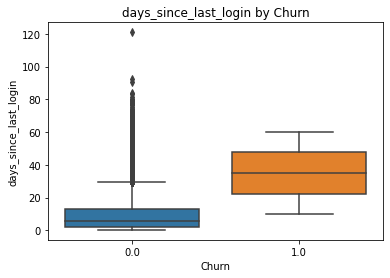

In [25]:
sns.boxplot(x="label", y="days_since_last_login", data=predicted_df).set_title('days_since_last_login by Churn')
plt.xlabel("Churn")
plt.ylabel("days_since_last_login")
plt.show()

# 8. Publish & deploy the machine learning pipeline to Big Data Analytics
Click on Publish to BDA and complete the form as follows:
- In User, type your Big Data Analytics username@magellan
- In Password, type your Big Data Analytics password
- In Repository, select Spark.
- In Name, type Customer Churn Model
- In Category, select Categorical Classifier
- The model path for this demo environment is hdfs://mag-hdp1/OpenText/models/PredictCustomerChurn. It uses the format hdfs://ambari/OpenText/models/<model_name>, without the final slash. This process will not create new folders. The folder that contains the model must exist. Step 6 will create the required folders for this. Example: type hdfs://mag-hdp1/OpenText/models/PredictCustomerChurn. Replace the name ambari with the hostname of your server running the Ambari dashboard, in this environment it's mag-hdp1
- In Dataframe variable, type trainingData, and choose Obtain. These are the input fields needed to run the pipeline from Big Data Analytics. Remove churn from the list since that is not required as an input. Also, remove "age_numeric"
- Set the versioning to Overwrite current version (so we don't end up with a million similar models)
- Set the security to Shared with me only, and choose Publish
- Close the window that says your model was published. Next, close the Publish dialog.
- Your analytic pipeline is now available for users in Big Data Analytics when they are connected to the Spark repository
- Apply new data with same inputs and execute model from Big Data Analytics

# Done!

# =============================================================

# Author

Arjun Arora is a Data Scientist at Opentext. He specializes in technology evangelism, data science training, demos, and proof of concepts, that leverage Opentext Magellan and Big Data technologies, such as, Apache Hadoop and Apache Spark. 